# Week 14 Discussion - Triangle Counting in PySpark

In [43]:
import time
import numpy as np
from prettytable import PrettyTable
from pyspark import SparkConf, SparkContext, SQLContext

# Setup spark context
conf = (SparkConf().setMaster("local").setAppName("My app").set("spark.executor.memory", "1g"))
sc = SparkContext(conf = conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=My app, master=local) created by __init__ at <ipython-input-30-28afcb986cb8>:8 

Now that we setup spark, lets load in our edge list for an example network from the assignment:

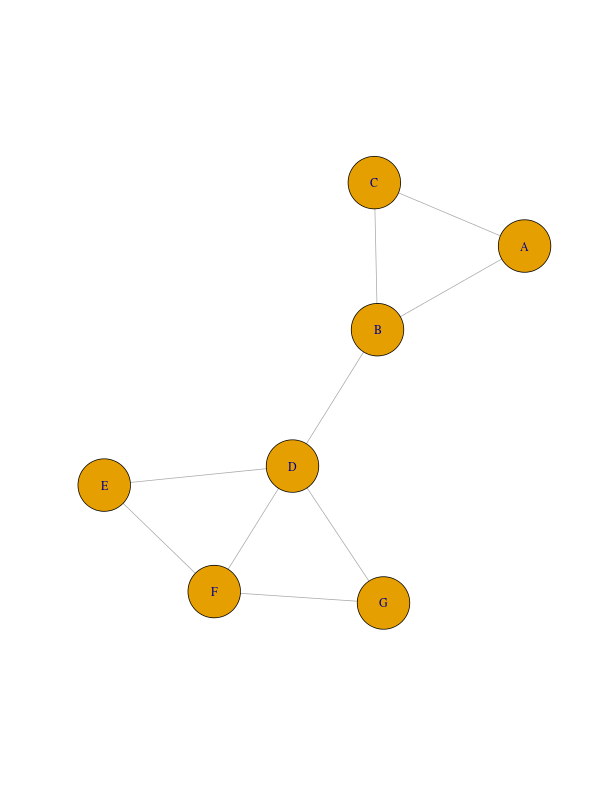

In [44]:
# Edges from homework example
edges = sc.parallelize([("A", "B"), 
                         ("A", "C"),
                         ("B", "C"),
                         ("B", "D"),
                         ("D", "E"),
                         ("D", "F"),
                         ("D", "G"),
                         ("E", "F"),
                         ("F", "G")])

# Lets show what graph this represents
from IPython.display import Image
Image(filename='graph1.png', width=400) 

From this edge list, lets map each edge to itself, to find all edge pairs. After that, we then do the map again, so we find all edge triples:

In [45]:
def find_edge_triplets(edges):
    ''' Given list of edges, compute all edge-triplets '''
    # Find cartesian product of cartesian product of edges with itself
    edges_cartesian = edges.cartesian(edges).map(lambda (x,y): (1, (x,y)) )

    # NOTE: not sure why I cannot do .cartesian twice, but gave me errors
    edges = edges.map(lambda (x): (1, x) )
    return edges.join(edges_cartesian)

First we define some functions. The function cleanup_edges will convert the edge list to a flat list of edge tuples (otherwise, its in the format (edge1, (edge2, edge3); this is not needed, just used for debugging. I will not analyze it as part of the runtime).

The function filter_edges filters out triplets based on whether or not it forms a triangle. This is done by matching nodes in the right position. Notice, we have an implicit ordering which we maintain when inputting the edges. The other funtions are obvious:

In [46]:
def cleanup_edges(pair):
    ''' Make the RDD a bit more readable, not needed'''
    key, value = pair
    edge1, edge23 = value
    edge2, edge3 = edge23
    return (edge1, edge2, edge3)

def filter_edges(value):
    ''' Given list of edges triplets, filter out the triangles '''
    edge1, edge2, edge3 = value
    if edge1[1] == edge2[0] and edge3[0] == edge1[0] and edge3[1] == edge2[1]:
        return True
    return False

def find_triangles(edge_triplets):
    ''' Given edge triplets, filter out triangles'''
    global cleanup_edges
    global filter_edges
    return edge_triplets.map(cleanup_edges).filter(filter_edges).collect()

def print_triangles(edge_triplets):
    ''' Given edge triplets, print out triangles'''
    # Find all the triangles
    triangles = find_triangles(edge_triplets)

    # Create pretty table for results
    x = PrettyTable(["Edge1", "Edge2", "Edge3"])
    for triangle in triangles:
        x.add_row([comp for comp in triangle]) 
    print x

Now lets run the algorithm on data from our assignment (part (a)):

In [47]:
edge_triplets = find_edge_triplets(edges)
print_triangles(edge_triplets)

+------------+------------+------------+
|   Edge1    |   Edge2    |   Edge3    |
+------------+------------+------------+
| ('A', 'B') | ('B', 'C') | ('A', 'C') |
| ('D', 'E') | ('E', 'F') | ('D', 'F') |
| ('D', 'F') | ('F', 'G') | ('D', 'G') |
+------------+------------+------------+


Lets look at the performance:

In [48]:
num_iters = 10
times = []

for i in range(num_iters):
    # Run our algorithm in spark to find all triangles
    start = time.time()
    edge_triplets = find_edge_triplets(edges)
    find_triangles(edge_triplets)
    end = time.time()
    times.append(end-start)
    print("Took %f seconds" % (end - start))

print("Mean: %f" % np.mean(times))

Took 0.345709 seconds
Took 0.327424 seconds
Took 0.354667 seconds
Took 0.361050 seconds
Took 0.340699 seconds
Took 0.368848 seconds
Took 0.346728 seconds
Took 0.360344 seconds
Took 0.346585 seconds
Took 0.346830 seconds
Mean: 0.349888


## Larger example

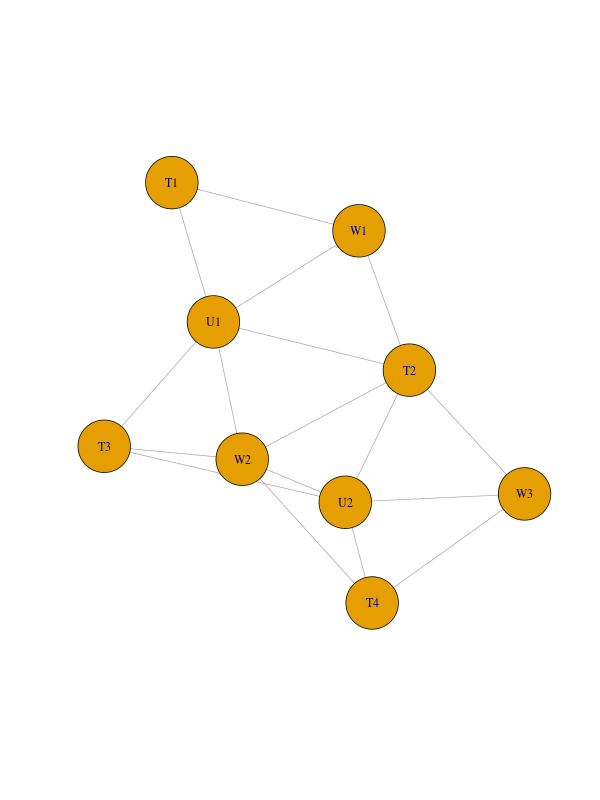

In [49]:
# Edges from homework example
larger_edges = sc.parallelize([(1,3),
                                (1,4),
                                (1,5),
                                (1,7),
                                (1,8),
                                (2,4),
                                (2,5),
                                (2,6),
                                (2,8),
                                (2,9),
                                (3,7),
                                (4,7),
                                (4,8),
                                (4,9),
                                (5,8),
                                (6,8),
                                (6,9)])

# Lets show what graph this represents
from IPython.display import Image
Image(filename='graph3.png', width=400) 

In [50]:
# Run our algorithm in spark to find all triangles
larger_edge_triplets = find_edge_triplets(larger_edges)
print_triangles(larger_edge_triplets)

+--------+--------+--------+
| Edge1  | Edge2  | Edge3  |
+--------+--------+--------+
| (1, 3) | (3, 7) | (1, 7) |
| (1, 4) | (4, 7) | (1, 7) |
| (1, 4) | (4, 8) | (1, 8) |
| (1, 5) | (5, 8) | (1, 8) |
| (2, 4) | (4, 8) | (2, 8) |
| (2, 4) | (4, 9) | (2, 9) |
| (2, 5) | (5, 8) | (2, 8) |
| (2, 6) | (6, 8) | (2, 8) |
| (2, 6) | (6, 9) | (2, 9) |
+--------+--------+--------+


In [51]:
num_iters = 10
times = []

for i in range(num_iters):
    # Run our algorithm in spark to find all triangles
    start = time.time()
    larger_edge_triplets = find_edge_triplets(larger_edges)
    find_triangles(larger_edge_triplets)
    end = time.time()
    times.append(end - start)
    print("Took %f seconds" % (end - start))

print("Mean: %f" % np.mean(times))

Took 0.335951 seconds
Took 0.368821 seconds
Took 0.333363 seconds
Took 0.357235 seconds
Took 0.358038 seconds
Took 0.320773 seconds
Took 0.383359 seconds
Took 0.339332 seconds
Took 0.346684 seconds
Took 0.350581 seconds
Mean: 0.349414


## Comparison to R

It looks like the spark implementation with Python takes about  0.36s to find all the triangles. The R code for the assignment took 0.09s for part (a), 0.11s for part (b) and 0.23s for part (c). There is a general increase as the size of the graph increases. With the Spark implementation, it seems consistently 0.36s (only part (a) and (c) are done here). This accords with my intuition: the Sprak implementation, like MR, has a high startup cost, so for small problems, it is noticable. This eventually gets amortized as the data grows. The hand coded R implementation relies heavily on igraph and it's performance will eventually get bad enough that the Spark implementation will beat it.

## Cleanup

In [52]:
sc.stop()